In [1]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [2]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Circuit Component Analysis/data/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Circuit Component Analysis/data/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Circuit Component Analysis/data/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)

Found 4200 images belonging to 20 classes.
Found 1800 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


# EfficientNetB0

In [3]:
input_layer = K.Input(shape=(160,160,3))
effnet_model = K.applications.EfficientNetB0(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in effnet_model.layers[:150]:
    layer.trainable = False
for i, layer in enumerate(effnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

16705208/16705208 [==============================] - 0s 0us/step
0 input_1 - False
1 rescaling - False
2 normalization - False
3 tf.math.truediv - False
4 stem_conv_pad - False
5 stem_conv - False
6 stem_bn - False
7 stem_activation - False
8 block1a_dwconv - False
9 block1a_bn - False
10 block1a_activation - False
11 block1a_se_squeeze - False
12 block1a_se_reshape - False
13 block1a_se_reduce - False
14 block1a_se_expand - False
15 block1a_se_excite - False
16 block1a_project_conv - False
17 block1a_project_bn - False
18 block2a_expand_conv - False
19 block2a_expand_bn - False
20 block2a_expand_activation - False
21 block2a_dwconv_pad - False
22 block2a_dwconv - False
23 block2a_bn - False
24 block2a_activation - False
25 block2a_se_squeeze - False
26 block2a_se_reshape - False
27 block2a_se_reduce - False
28 block2a_se_expand - False
29 block2a_se_excite - False
30 block2a_project_conv - False
31 block2a_project_bn - False
32 block2b_expand_conv - False
33 block2b_expand_bn - False


In [4]:
def recall_m(y_true, y_pred):
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + Kback.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+Kback.epsilon()))

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc')
]

In [5]:
inputs = K.layers.Input(shape=(160,160,3), name="image")  

resnet50 = effnet_model(inputs)
flat = K.layers.GlobalAveragePooling2D()(resnet50)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 4,075,191
Trainable params: 3,313,324
Non-trainable params: 761,867
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [7]:
checkpoint_filepath = '/'
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/150
66/66 [==============================] - 1428s 22s/step - loss: 2.9208 - accuracy: 0.0962 - precision: 0.5000 - recall: 0.0060 - auc: 0.6045 - val_loss: 3.0054 - val_accuracy: 0.0500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5023
Epoch 2/150
66/66 [==============================] - 14s 204ms/step - loss: 2.3127 - accuracy: 0.2483 - precision: 0.6270 - recall: 0.1105 - auc: 0.8001 - val_loss: 3.1174 - val_accuracy: 0.0500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5073
Epoch 3/150
66/66 [==============================] - 13s 204ms/step - loss: 1.9835 - accuracy: 0.3514 - precision: 0.6985 - recall: 0.2107 - auc: 0.8595 - val_loss: 3.0203 - val_accuracy: 0.0500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5082
Epoch 4/150
66/66 [==============================] - 14s 208ms/step - loss: 1.7987 - accuracy: 0.4162 - precision: 0.7559 - recall: 0.3045 - auc: 0.8821 - val_loss: 3.3144 - val_accuracy: 0.0500 - val_p

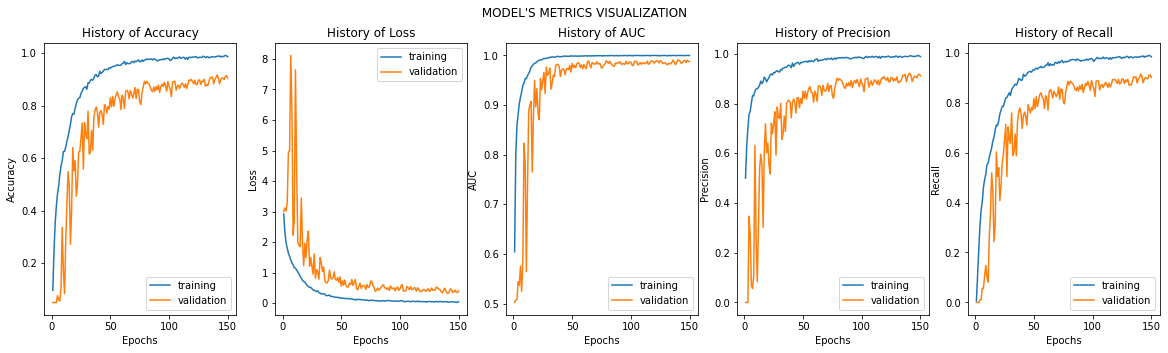

In [8]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall):
    
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall']
              )

In [9]:
model.save('efficientnetB0_semitransfer.hdf5')

# Testing

In [11]:
def f1_score(precision,recall):
    return (2*precision*recall)/(precision+recall)

model = K.models.load_model("efficientnetB0_semitransfer.hdf5")
loss,accuracy,precision,recall,auc = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print(" Testing F1-Score:")
print(f1_score(precision,recall))
print("Testing AUC:")
print(auc)

32/32 [==============================] - 489s 16s/step - loss: 2.0221 - accuracy: 0.6445 - precision: 0.6672 - recall: 0.6375 - auc: 0.9065
Testing Loss:
2.0221340656280518
Testing Accuracy:
0.6445000171661377
Testing Precision:
0.6671899557113647
Testing Recall:
0.637499988079071
 Testing F1-Score:
0.6520071543998803
Testing AUC:
0.9065361618995667


<ipython-input-12-918290b6fc63>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


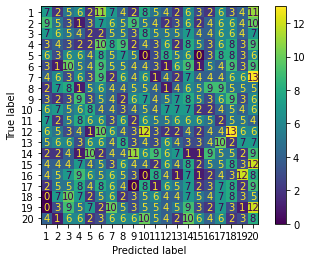

Classification Report
              precision    recall  f1-score   support

           1       0.08      0.07      0.08       100
           2       0.06      0.05      0.05       100
           3       0.05      0.05      0.05       100
           4       0.02      0.02      0.02       100
           5       0.05      0.04      0.04       100
           6       0.07      0.09      0.08       100
           7       0.02      0.02      0.02       100
           8       0.04      0.04      0.04       100
           9       0.07      0.06      0.07       100
          10       0.04      0.05      0.05       100
          11       0.06      0.05      0.05       100
          12       0.02      0.02      0.02       100
          13       0.05      0.04      0.04       100
          14       0.01      0.01      0.01       100
          15       0.03      0.02      0.02       100
          16       0.02      0.02      0.02       100
          17       0.06      0.07      0.06       100
     

In [12]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))